Topic	Contents
0. Computer vision libraries in PyTorch:	PyTorch has a bunch of built-in helpful computer vision libraries, let's check them out.
1. Load data:	To practice computer vision, we'll start with some images of different pieces of clothing from FashionMNIST.
2. Prepare data:	We've got some images, let's load them in with a PyTorch DataLoader so we can use them with our training loop.
3. Model 0: Building a baseline model	Here we'll create a multi-class classification model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.
4. Making predictions and evaluating model 0:	Let's make some predictions with our baseline model and evaluate them.
5. Setup device agnostic code for future models:	It's best practice to write device-agnostic code, so let's set it up.
6. Model 1: Adding non-linearity:	Experimenting is a large part of machine learning, let's try and improve upon our baseline model by adding non-linear layers.
7. Model 2: Convolutional Neural Network (CNN):	Time to get computer vision specific and introduce the powerful convolutional neural network architecture.
8. Comparing our models:	We've built three different models, let's compare them.
9. Evaluating our best model:	Let's make some predictions on random images and evaluate our best model.
10. Making a confusion matrix: A confusion matrix is a great way to evaluate a classification model, let's see how we can make one.
11. Saving and loading the best performing model:	Since we might want to use our model for later, let's save it and make sure it loads back in correctly.


In [123]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [125]:
dir(train_data)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_check_legacy_exist',
 '_format_transform_repr',
 '_is_protocol',
 '_load_data',
 '_load_legacy_data',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'data',
 'download',
 'extra_repr',
 'mirrors',
 'processed_folder',
 'raw_folder',
 'resources',
 'root',
 'target_transform',
 'targets',
 'test_data',
 'test_file',
 'test_labels',
 'train',
 'train_data',
 'train_labels',
 'training_file',
 'transform',
 'transforms']

In [126]:
# First look our data (first image)
image, label = train_data[0]

# Get inform
print(f"Image shape: {image.shape}")
print(f"Label shape: {label}")

# [color_channels=1, height=28, width=28]
# Having color_channels=1 means the image is grayscale.

Image shape: torch.Size([1, 28, 28])
Label shape: 9


In [127]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

# We get 60k train samples and 10k test samples

(60000, 60000, 10000, 10000)

In [128]:
# How many classes are there?
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Image shape torch.Size([1, 28, 28])
Label ['Ankle boot']


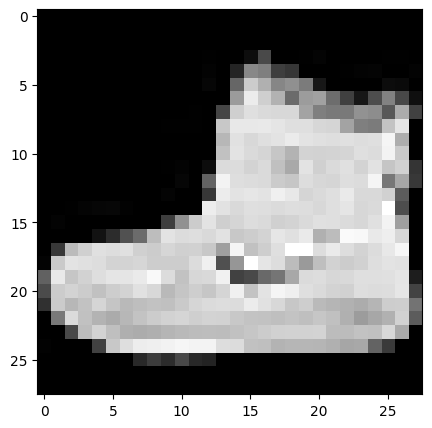

In [129]:
# Visualize data
print('Image shape', image.shape)
print('Label', [key for key, val in train_data.class_to_idx.items() if val==label])

plt.figure(figsize=(10, 5))
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

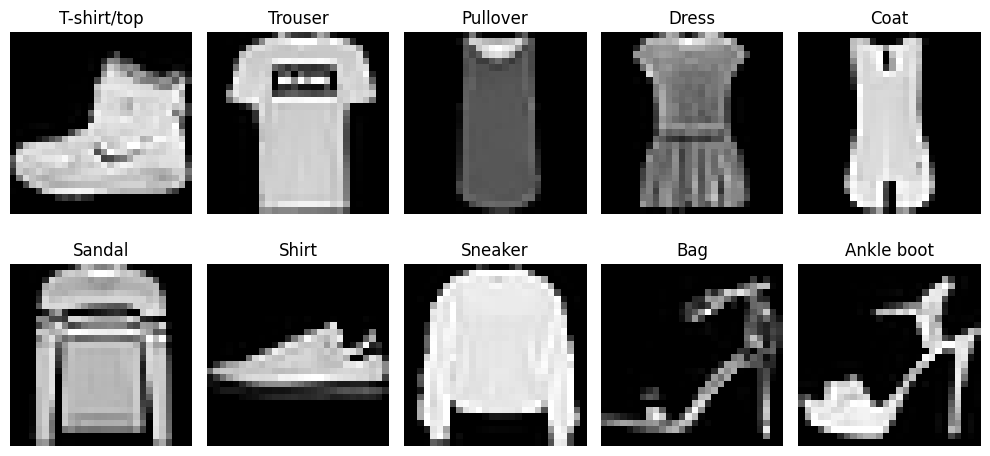

In [130]:
# Visualize all label
unique_label = np.unique(train_data.targets)
class_name = train_data.classes
unique_image = [train_data[i][0] for i in unique_label]

# There are ten labels
fig = plt.figure(figsize=(10, 5))
rows, cols = 2, 5
for idx in range(1, rows*cols+1):
  fig.add_subplot(rows, cols, idx)
  image, label = unique_image[idx-1], unique_label[idx-1]
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(class_name[label])
  plt.axis(False)
plt.tight_layout()
plt.show()

In [131]:
### Prepare the DataLoader

# The next step is to prepare it with a torch.utils.data.DataLoader or DataLoader for short.

# The DataLoader does what you think it might do.
# It helps load data into a model.
# For training and for inference.
# It turns a large Dataset into a Python iterable of smaller chunks.
# These smaller chunks are called batches or mini-batches and can be set by the batch_size parameter.

# Why do this?

# Because it's more computationally efficient.
# In an ideal world you could do the forward pass and backward pass across all of your data at once.
# But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.
# It also gives your model more opportunities to improve.
# With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

# What's a good batch size?
# 32 is a good place to start for a fair amount of problems.
# But since this is a value you can set (a hyperparameter) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).

In [132]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch

In [133]:
# Setup batch size as a hyperparameter
# Batch size is number of samples per batch
# Number of batches = len(dataset) / batch size
BATCH_SIZE = 32 # Good for all scenarios

# Turn dataset into batches
train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False) # No necessary to shuffle test data

# Check out what was create
print(f"Dataloaders: {train_loader, test_loader}")
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x78e6bd3292d0>, <torch.utils.data.dataloader.DataLoader object at 0x78e6c02c08d0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [134]:
dir(train_loader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_

In [135]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

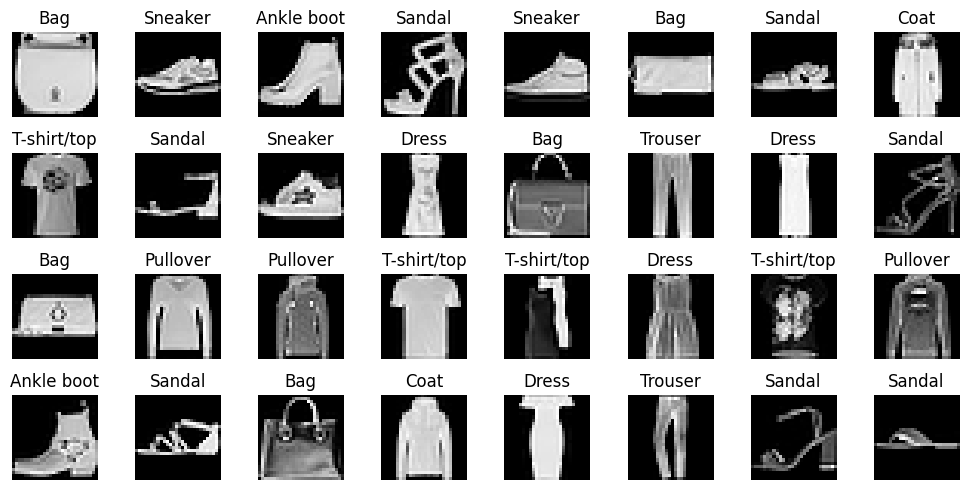

In [136]:
# Visualize all samples in one batch
fig = plt.figure(figsize=(10, 5))
rows, cols = 4, 8
for idx in range(1, rows*cols+1):
  fig.add_subplot(rows, cols, idx)
  image, label = train_features_batch[idx-1], train_labels_batch[idx-1]
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(class_name[label])
  plt.axis(False)
plt.tight_layout()
plt.show()

**Build a Baseline Model (Model 0)**

In [137]:
### Get to know with Flatten (nn.Flatten)

# The nn.Flatten() layer took our shape from [color_channels, height, width] to [color_channels, height*width].
# Why do this?
# Because we've now turned our pixel data from height and width dimensions into one long feature vector.
# And nn.Linear() layers like their inputs to be in the form of feature vectors.

# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [138]:
### See what happen
print(x)
print(output)

tensor([[[0.0000, 0.0000, 0.0000, 0.3529, 0.8235, 0.6392, 0.8588, 0.8353,
          0.7490, 0.7098, 0.6902, 0.6902, 0.6902, 0.6745, 0.6471, 0.6510,
          0.6471, 0.6431, 0.6157, 0.6392, 0.5804, 0.7216, 0.6784, 0.6471,
          0.5647, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7686, 0.5059, 0.0000, 0.1569, 0.9882,
          0.8980, 0.8667, 0.8784, 0.8745, 0.8706, 0.9098, 0.9255, 0.9216,
          0.8745, 0.8706, 0.8745, 0.8667, 0.9098, 0.9569, 0.2000, 0.2000,
          0.7961, 0.4902, 0.0000, 0.0039],
         [0.0000, 0.0000, 0.0000, 0.6706, 0.0039, 0.0000, 0.0000, 0.6000,
          0.8667, 0.8392, 0.8627, 0.8627, 0.8667, 0.8627, 0.8510, 0.8549,
          0.8510, 0.8510, 0.8510, 0.8353, 0.8431, 0.3137, 0.0039, 0.0000,
          0.3569, 0.5529, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7137, 0.3765, 0.3333, 0.6784, 0.6549,
          0.5804, 0.6902, 0.7333, 0.7529, 0.7843, 0.8078, 0.8314, 0.8157,
          0.8000, 0.7882, 0.7373, 0.6667, 0.7020, 0.6118,

In [139]:
# Let's build a basic model
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_features: int, hidden_units: int, output_features: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),  # Allows to covert our dataset from [c, h, w] to [c, h*w]
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [140]:
# Initialize model following...
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_features=784, # one for every pixel (28x28), just because we have a flatten layer first
    hidden_units=10, # how many units in the hidden layer
    output_features=len(class_name) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [141]:
try:
  import torchmetrics
except:
  !pip install torchmetrics -q
  import torchmetrics

In [142]:
### Setup loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

# Also accuracy score to evaluate model
# Loss -> How model fails
# Accuracy (or other metrics) -> How model makes correctly
from torchmetrics import Accuracy
accuracy = Accuracy(task = 'multiclass', num_classes=len(class_name)).to('cpu')

In [143]:
# Let's step through it:

# 1. Loop through epochs.
# 2. Loop through training batches, perform training steps, calculate the train loss per batch.
# 3. Loop through testing batches, perform testing steps, calculate the test loss per batch.
# 4. Print out what's happening.

In [144]:
### Get to know tqdm
from tqdm import tqdm
import time

for i in tqdm(range(10)):
    time.sleep(0.5)

100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


In [145]:
import time

# Random seed
torch.manual_seed(42)

# Set epochs
epochs = 5

start_time = time.time()
# Create training loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  ### Training
  train_loss = 0

  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(train_loader):
    # Setup training mode
    model_0.train()

    # Forward pass
    y_pred = model_0(X)

    # Compute loss
    loss = criterion(y_pred, y)
    train_loss += loss # accumulatively add up the loss per epoch

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples")

  # Divide total train loss by length of train dataloader (average loss per batch per epoch)
  train_loss /= len(train_loader)

  ### Evaluating
  test_loss, test_acc = 0, 0

  # Setup evaluating mode
  model_0.eval()

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through testing batches
    for X, y in test_loader:
      # Forward pass
      test_pred = model_0(X)
      # Compute loss
      test_loss += criterion(test_pred, y)
      # Compute accuracy
      test_acc += accuracy(test_pred.argmax(dim=1), y)

    # Calculations on test metrics need to happen inside torch.inference_mode()
    # Divide total test loss by length of test dataloader (per batch)
    test_loss /= len(test_loader)

    # Divide total accuracy by length of test dataloader (per batch)
    test_acc /= len(test_loader)

  ### Print out what's happening
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
  print('-'*30)
end_time = time.time()
model_v0_training_time = end_time - start_time
print(f'===== Traning time:{model_v0_training_time} =====')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 20%|██        | 1/5 [00:19<01:19, 19.79s/it]


Train loss: 0.56452 | Test loss: 0.50877, Test acc: 0.82%

------------------------------
Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 40%|████      | 2/5 [00:32<00:46, 15.35s/it]


Train loss: 0.50134 | Test loss: 0.48985, Test acc: 0.83%

------------------------------
Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 60%|██████    | 3/5 [00:43<00:26, 13.42s/it]


Train loss: 0.48092 | Test loss: 0.57256, Test acc: 0.80%

------------------------------
Epoch: 3
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 80%|████████  | 4/5 [00:58<00:14, 14.04s/it]


Train loss: 0.47964 | Test loss: 0.53968, Test acc: 0.82%

------------------------------
Epoch: 4
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 5/5 [01:15<00:00, 15.05s/it]


Train loss: 0.47799 | Test loss: 0.49451, Test acc: 0.83%

------------------------------
===== Traning time:75.25752210617065 =====


In [146]:
def eval_model(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module):
  loss, acc = 0, 0
  accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_name)).to('cpu')
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      y_pred = model(X)
      loss += criterion(y_pred, y)
      acc += accuracy(y_pred.argmax(dim=1), y)
    loss /= len(dataloader)
    acc /= len(dataloader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc.item()}

In [147]:
eval_report_model_v0 = eval_model(model_0,
                                test_loader,
                                criterion)
eval_report_model_v0

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.494508296251297,
 'model_acc': 0.8316693305969238}

**More Complex Model**

In [148]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_features: int, hidden_units: int, output_features: int):
    super().__init__()
    self.stack_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Tanh(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units*2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units*2, out_features=output_features),
        nn.Softplus()
    )

  def forward(self, x):
    return self.stack_layer(x)

In [149]:
# Initial model
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(
    input_features=784,
    hidden_units=10,
    output_features=len(class_name))

model_1.to('cpu')

FashionMNISTModelV1(
  (stack_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Tanh()
    (3): Linear(in_features=10, out_features=20, bias=True)
    (4): ReLU()
    (5): Linear(in_features=20, out_features=10, bias=True)
    (6): Softplus(beta=1.0, threshold=20.0)
  )
)

In [150]:
# Setup loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)
accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_name)).to('cpu')

In [151]:
def training_step(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  criterion: nn.Module,
                  metric: torchmetrics.Metric,
                  optimizer: torch.optim.Optimizer,
                  device='cpu'):
    # Put model to device
    model.to(device)
    metric.to(device)

    # Initialize variables to store important scores
    train_loss = 0
    train_metric = 0

    # Reset metric before epoch
    metric.reset()

    # Training mode
    model.train()
    for X, y in data_loader:
        # Send data to device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred, y)

        # Update loss and metric
        train_loss += loss.item()
        train_metric += metric(y_pred.argmax(dim=1), y).item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute average
    train_loss /= len(data_loader)
    train_metric /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train {metric.__class__.__name__}: {train_metric:.5f}\n")


In [152]:
def evaluation_step(model: nn.Module,
                    data_loader: torch.utils.data.DataLoader,
                    criterion: nn.Module,
                    metric: torchmetrics.Metric,
                    device='cpu'):
    # Put model to device
    model.to(device)
    metric.to(device)

    # Initialize variables to store important scores
    test_loss = 0
    test_metric = 0

    # Reset metric before evaluation
    metric.reset()

    # Setup mode
    model.eval()

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)
            loss = criterion(y_pred, y)

            # Update loss and metric
            test_loss += loss.item()
            test_metric += metric(y_pred.argmax(dim=1), y).item()

        # Compute average
        test_loss /= len(data_loader)
        test_metric /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test {metric.__class__.__name__}: {test_metric:.5f}\n")


In [174]:
epochs = 5
import time

start_time = time.time()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  training_step(model=model_1,
                data_loader=train_loader,
                criterion=criterion,
                metric=accuracy,
                optimizer=optimizer)
  evaluation_step(model=model_1,
                  data_loader=test_loader,
                  criterion=criterion,
                  metric=accuracy)
  print('-'*30)
end_time = time.time()
model_v1_training_time = end_time - start_time
print(f'===== Traning time:{model_v1_training_time} =====')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58829 | Train MulticlassAccuracy: 0.80070



 20%|██        | 1/5 [00:12<00:50, 12.52s/it]

Test loss: 0.63053 | Test MulticlassAccuracy: 0.78894

------------------------------
Epoch: 1
---------
Train loss: 0.58829 | Train MulticlassAccuracy: 0.80070



 40%|████      | 2/5 [00:27<00:41, 13.82s/it]

Test loss: 0.63053 | Test MulticlassAccuracy: 0.78894

------------------------------
Epoch: 2
---------
Train loss: 0.58829 | Train MulticlassAccuracy: 0.80070



 60%|██████    | 3/5 [00:39<00:26, 13.14s/it]

Test loss: 0.63053 | Test MulticlassAccuracy: 0.78894

------------------------------
Epoch: 3
---------
Train loss: 0.58829 | Train MulticlassAccuracy: 0.80070



 80%|████████  | 4/5 [00:51<00:12, 12.80s/it]

Test loss: 0.63053 | Test MulticlassAccuracy: 0.78894

------------------------------
Epoch: 4
---------
Train loss: 0.58829 | Train MulticlassAccuracy: 0.80070



100%|██████████| 5/5 [01:04<00:00, 13.00s/it]

Test loss: 0.63053 | Test MulticlassAccuracy: 0.78894

------------------------------
===== Traning time:64.98619890213013 =====


In [175]:
eval_report_model_v1 = eval_model(model_1,
                                  test_loader,
                                  nn.CrossEntropyLoss())
eval_report_model_v1

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6305336952209473,
 'model_acc': 0.7889376878738403}

**CNN: Convolution Neural Network**

In [176]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [177]:
torch.manual_seed(42)

model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_name))
model_2.to('cpu')

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

##### **Phân tích Model**
**=== Block 1 ===**

(0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    Bộ lọc: 10 filters kích thước 3×3.
    Input: Ảnh đầu vào có kích thước (1, 28, 28) (1 kênh x 28x28 pixels).
    Output: Do padding=1, kích thước đầu ra giữ nguyên (10, 28, 28).
    Vai trò: Trích xuất đặc trưng từ ảnh.

(1): ReLU()
   
    Áp dụng activation function ReLU để tăng tính phi tuyến cho mô hình.
(2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    Bộ lọc: 10 filters 3×3.
    Input: Tensor có kích thước (10, 28, 28).
    Output: Kích thước giữ nguyên (10, 28, 28).
    Vai trò: Tiếp tục trích xuất đặc trưng sau lần tích chập đầu tiên.
(3): ReLU()

    Giữ lại giá trị dương, loại bỏ giá trị âm.
(4): MaxPool2d(kernel_size=2, stride=2, padding=0)

    Kích thước kernel: 2×2, stride=2.
    Input: (10, 28, 28).
    Output: (10, 14, 14).
    Vai trò: Giảm kích thước không gian, giảm số tham số, giúp mô hình học hiệu quả hơn.

**=== Block 2 ===**

(0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    Bộ lọc: 10 filters 3×3.
    Input: (10, 14, 14).
    Output: (10, 14, 14).
(1): ReLU()

    Giữ lại thông tin quan trọng.
(2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    Bộ lọc: 10 filters 3×3.
    Input: (10, 14, 14).
    Output: (10, 14, 14).
(3): ReLU()

    Áp dụng hàm kích hoạt
(4): MaxPool2d(kernel_size=2, stride=2, padding=0)

    Input: (10, 14, 14).
    Output: (10, 7, 7).
    Vai trò: Giảm kích thước, giúp giảm số lượng tham số.

**=== Classifier ===**

(0): Flatten(start_dim=1, end_dim=-1)

    Input: (10, 7, 7).
    Output: (1, 10×7×7) = (1, 490).
    Vai trò: Chuyển tensor 3D thành vector 1D để đưa vào MLP.
(1): Linear(in_features=490, out_features=10, bias=True)

    Fully Connected Layer với đầu vào 490 và đầu ra 10 (tương ứng với 10 classes của FashionMNIST).
    Output: (1, 10).
    Vai trò: Dự đoán xác suất cho từng lớp.

## Bảng kích thước đầu ra của từng layer trong FashionMNISTModelV2

| Layer | Input Shape | Output Shape | Vai trò |
|--------|------------|-------------|---------|
| **Conv2d(1,10,3,1,1)** | (1, 28, 28) | (10, 28, 28) | Trích xuất đặc trưng |
| **ReLU** | (10, 28, 28) | (10, 28, 28) | Phi tuyến |
| **Conv2d(10,10,3,1,1)** | (10, 28, 28) | (10, 28, 28) | Tiếp tục trích xuất đặc trưng |
| **ReLU** | (10, 28, 28) | (10, 28, 28) | Phi tuyến |
| **MaxPool2d(2,2)** | (10, 28, 28) | (10, 14, 14) | Giảm kích thước |
| **Conv2d(10,10,3,1,1)** | (10, 14, 14) | (10, 14, 14) | Trích xuất đặc trưng sâu hơn |
| **ReLU** | (10, 14, 14) | (10, 14, 14) | Phi tuyến |
| **Conv2d(10,10,3,1,1)** | (10, 14, 14) | (10, 14, 14) | Tiếp tục trích xuất đặc trưng |
| **ReLU** | (10, 14, 14) | (10, 14, 14) | Phi tuyến |
| **MaxPool2d(2,2)** | (10, 14, 14) | (10, 7, 7) | Giảm kích thước |
| **Flatten** | (10, 7, 7) | (1, 490) | Chuyển tensor thành vector |
| **Linear(490,10)** | (1, 490) | (1, 10) | Dự đoán lớp |


In [178]:
# Let walk through Conv2D
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [179]:
torch.manual_seed(42)

conv2d_layer = nn.Conv2d(in_channels=3,
                         out_channels=10,
                         kernel_size=3,
                         padding=1,
                         stride=1)
conv2d_layer(test_image)

tensor([[[ 1.3047,  1.4238,  0.9435,  ...,  0.3078,  0.4244, -0.3909],
         [ 0.6132,  1.5396,  0.0516,  ...,  0.8711,  0.4256, -0.3416],
         [ 1.0524,  0.3662,  1.0114,  ...,  0.2809, -0.2741,  0.3787],
         ...,
         [ 0.0377,  0.2981, -0.2432,  ..., -0.7283, -0.5767, -0.0783],
         [-0.2693, -0.0386, -0.0781,  ...,  0.4228, -0.1802, -0.5140],
         [ 0.5006, -0.5684,  0.1166,  ...,  0.5425, -0.3335,  0.7756]],

        [[-0.1153,  0.5129, -0.7227,  ..., -0.6758,  0.4840, -0.8125],
         [ 0.2266, -0.2840, -0.0319,  ...,  1.5599, -1.2449, -0.4410],
         [-0.6666,  0.2753, -0.1262,  ...,  0.1999, -0.8856, -0.4292],
         ...,
         [-0.0647, -0.1984, -0.6386,  ..., -0.0585, -0.7833, -0.0764],
         [ 0.2940, -0.6306, -0.2052,  ...,  0.2456, -0.7134,  0.7373],
         [-0.1683, -0.8397,  0.2643,  ...,  0.2593, -0.5630,  0.1587]],

        [[ 0.4864, -0.7476, -0.6414,  ...,  0.5477, -1.2156,  0.2989],
         [-0.5791,  0.4414,  0.5100,  ...,  0

In [180]:
dim = [0, 1, 2, 3, 4, 5, 6]
print(f'Original shape: {test_image.shape}')
for i in dim:
  try:
    print(f'Dim={i} - Got shape: {test_image.unsqueeze(dim=i).shape}')
  except:
    print(f'Dim={i} - Failed')

Original shape: torch.Size([3, 64, 64])
Dim=0 - Got shape: torch.Size([1, 3, 64, 64])
Dim=1 - Got shape: torch.Size([3, 1, 64, 64])
Dim=2 - Got shape: torch.Size([3, 64, 1, 64])
Dim=3 - Got shape: torch.Size([3, 64, 64, 1])
Dim=4 - Failed
Dim=5 - Failed
Dim=6 - Failed


In [181]:
# Unsqueeze shape image for checkking dimension
test_image.unsqueeze(dim=0).shape

# [1, 3, 64, 64] states for [batch_Size, color_channels, height, width]

torch.Size([1, 3, 64, 64])

In [182]:
# Pass test image with extra dimension through conv_layer
conv2d_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 64, 64])

In [183]:
torch.manual_seed(42)
# Create a new conv_layer with different values (try setting these to whatever you like)
conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

# Pass single image through new conv_layer_2 (this calls nn.Conv2d()'s forward() method on the input)
conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

**Cách tính kích thước đầu ra**

$
W_{out} = \frac{W_{in}+2P-K}{S}+1
$

$
H_{out} = \frac{H_{in}+2P-K}{S}+1
$

In [184]:
### Check parameter's shapes of our model

# Get shapes of weight and bias tensors within conv_layber_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


In [185]:
### Max Pooling 2d
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv2d_layer
test_image_through_conv = conv2d_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv2d_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv2d_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv2d_layer(): torch.Size([1, 10, 64, 64])
Shape after going through conv2d_layer() and max_pool_layer(): torch.Size([1, 10, 32, 32])


In [186]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [187]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a avg pool layer
avg_pool_layer = nn.AvgPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the avg pool layer
avg_pool_tensor = avg_pool_layer(random_tensor)
print(f"\navg pool tensor:\n{avg_pool_tensor} <- this is the avg value from random_tensor")
print(f"avg pool tensor shape: {avg_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

avg pool tensor:
tensor([[[[0.2326]]]]) <- this is the avg value from random_tensor
avg pool tensor shape: torch.Size([1, 1, 1, 1])


**Training Model2**

In [188]:
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [189]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                             lr=0.1)

In [190]:
epochs = 5
import time

start_time = time.time()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  training_step(model=model_2,
                data_loader=train_loader,
                criterion=criterion,
                metric=accuracy,
                optimizer=optimizer)
  evaluation_step(model=model_2,
                  data_loader=test_loader,
                  criterion=criterion,
                  metric=accuracy)
  print('-'*30)
end_time = time.time()
model_v2_training_time = end_time - start_time
print(f'===== Traning time:{model_v2_training_time} =====')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.57780 | Train MulticlassAccuracy: 0.78945



 20%|██        | 1/5 [01:06<04:27, 66.79s/it]

Test loss: 0.42388 | Test MulticlassAccuracy: 0.84685

------------------------------
Epoch: 1
---------
Train loss: 0.35247 | Train MulticlassAccuracy: 0.87280



 40%|████      | 2/5 [02:07<03:09, 63.31s/it]

Test loss: 0.34050 | Test MulticlassAccuracy: 0.88319

------------------------------
Epoch: 2
---------
Train loss: 0.31417 | Train MulticlassAccuracy: 0.88663



 60%|██████    | 3/5 [03:14<02:10, 65.13s/it]

Test loss: 0.31718 | Test MulticlassAccuracy: 0.88448

------------------------------
Epoch: 3
---------
Train loss: 0.29400 | Train MulticlassAccuracy: 0.89333



 80%|████████  | 4/5 [04:14<01:02, 62.81s/it]

Test loss: 0.31381 | Test MulticlassAccuracy: 0.88369

------------------------------
Epoch: 4
---------
Train loss: 0.27867 | Train MulticlassAccuracy: 0.90003



100%|██████████| 5/5 [05:12<00:00, 62.45s/it]

Test loss: 0.29696 | Test MulticlassAccuracy: 0.89197

------------------------------
===== Traning time:312.2764484882355 =====


In [191]:
torch.manual_seed(42)
eval_report_model_v2 = eval_model(model_2, test_loader, nn.CrossEntropyLoss())
eval_report_model_v2

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2969551980495453,
 'model_acc': 0.8919728398323059}

In [192]:
import pandas as pd

report_model = pd.DataFrame([eval_report_model_v0, eval_report_model_v1, eval_report_model_v2], index=['Mode 0', 'Model 1', 'Model 2'])
training_times_df = pd.DataFrame({'training_time': [model_v0_training_time, model_v1_training_time, model_v2_training_time]}, index=['Mode 0', 'Model 1', 'Model 2'])

# Concatenate the two DataFrames horizontally
report_model = pd.concat([report_model, training_times_df], axis=1)
report_model

,model_name,model_loss,model_acc,training_time
Mode 0,FashionMNISTModelV0,0.494508,0.831669,75.257522
Model 1,FashionMNISTModelV1,0.630534,0.788938,64.986199
Model 2,FashionMNISTModelV2,0.296955,0.891973,312.276448


**Make Predictions**

In [197]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = 'cpu'):
    pred_labels = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_label = torch.softmax(pred_logit.squeeze(), dim=0).argmax(dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_label off GPU for further calculations
            pred_labels.append(pred_label.cpu())

    # Stack the pred_labels to turn list into a tensor
    return torch.stack(pred_labels)

In [198]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_name[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [199]:
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [200]:
# ModelV0
pred_labels_v0 = make_predictions(model=model_0, data=test_samples, device='cpu')

# ModelV1
pred_labels_v1 = make_predictions(model=model_1, data=test_samples, device='cpu')

# ModelV2
pred_labels_v2 = make_predictions(model=model_2, data=test_samples, device='cpu')



In [202]:
# Dataframe for comparision model
pred_labels_df = pd.DataFrame([pred_labels_v0, pred_labels_v1, pred_labels_v2, test_labels], index=['Mode 0', 'Model 1', 'Model 2', 'True Label'])
pred_labels_df

,0,1,2,3,4,5,6,7,8
Mode 0,tensor(9),tensor(3),tensor(9),tensor(4),tensor(3),tensor(0),tensor(4),tensor(7),tensor(1)
Model 1,tensor(5),tensor(3),tensor(7),tensor(4),tensor(3),tensor(0),tensor(4),tensor(7),tensor(1)
Model 2,tensor(5),tensor(1),tensor(7),tensor(4),tensor(3),tensor(6),tensor(4),tensor(7),tensor(1)
True Label,5,1,7,4,3,0,4,7,1


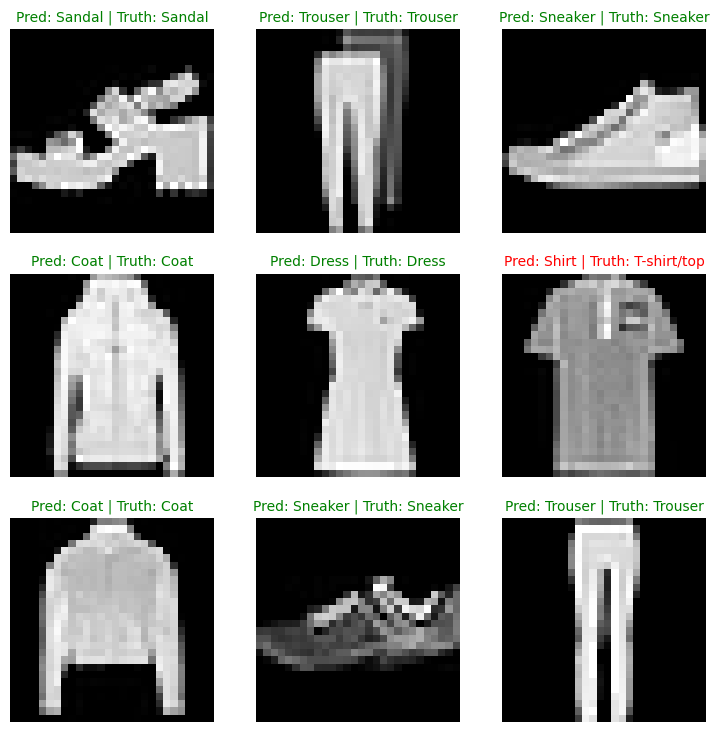

In [203]:
# Visualize model 2 result
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_name[pred_labels_v2[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_name[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [204]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "fashion_mnist_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/fashion_mnist_model.pth


In [206]:
loaded_model = FashionMNISTModelV2(input_shape=1, output_shape=10, hidden_units=10)
# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to('cpu')

<ipython-input-206-aa872fcccdd6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
